In [1]:
%matplotlib inline
import caffe
import numpy as np
import matplotlib.pyplot as plt
import os

/state/partition1/llgrid/pkg/anaconda2-4.4.0/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# using vgg net, loading takes several seconds, as does net.forward()
caffe_root = '/home/gridsan/salford/caffe/'
model_def = caffe_root + 'models/default_vgg_16/deploy.prototxt'
model_weights = caffe_root + 'models/default_vgg_16/vgg_16.caffemodel'
net = caffe.Net(model_def, model_weights, caffe.TEST)

In [5]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
# net.blobs['data'].reshape(50, 3, 227, 227)

# try using image size 224x224 for VGG?
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227


/state/partition1/llgrid/pkg/anaconda2-4.4.0/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


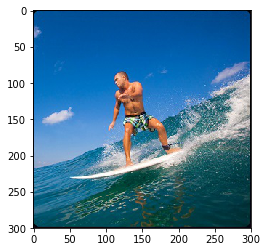

In [7]:
image = caffe.io.load_image('/home/gridsan/salford/surfer.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [9]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification - this also takes several seconds.
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 477


In [10]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02966687 carpenter's kit, tool kit


In [11]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.0018900735, "n02966687 carpenter's kit, tool kit"),
 (0.0017596526, 'n07711569 mashed potato'),
 (0.0017207912, "n03992509 potter's wheel"),
 (0.0016843098, 'n02111500 Great Pyrenees'),
 (0.0016470707, 'n03179701 desk')]

In [12]:
%timeit net.forward()

1 loop, best of 3: 5.19 s per loop


In [13]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 224, 224)
conv1_1	(50, 64, 224, 224)
conv1_2	(50, 64, 224, 224)
pool1	(50, 64, 112, 112)
conv2_1	(50, 128, 112, 112)
conv2_2	(50, 128, 112, 112)
pool2	(50, 128, 56, 56)
conv3_1	(50, 256, 56, 56)
conv3_2	(50, 256, 56, 56)
conv3_3	(50, 256, 56, 56)
pool3	(50, 256, 28, 28)
conv4_1	(50, 512, 28, 28)
conv4_2	(50, 512, 28, 28)
conv4_3	(50, 512, 28, 28)
pool4	(50, 512, 14, 14)
conv5_1	(50, 512, 14, 14)
conv5_2	(50, 512, 14, 14)
conv5_3	(50, 512, 14, 14)
pool5	(50, 512, 7, 7)
fc6_retrain	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [14]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
print('\nblob:')
for blob_name, param in net.blobs.iteritems():
    print blob_name + '\t' + str(param.data.shape)

conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
fc6_retrain	(4096, 25088) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)

blob:
data	(50, 3, 224, 224)
conv1_1	(50, 64, 224, 224)
conv1_2	(50, 64, 224, 224)
pool1	(50, 64, 112, 112)
conv2_1	(50, 128, 112, 112)
conv2_2	(50, 128, 112, 112)
pool2	(50, 128, 56, 56)
conv3_1	(50, 256, 56, 56)
conv3_2	(50, 256, 56, 56)
conv3_3	(50, 256, 56, 56)
pool3	(50, 256, 28, 28)
conv4_1	(50, 512, 28, 28)
conv4_2	(50, 512, 28, 28)
conv4_3	(50, 512, 28, 28)
pool4	(50, 512, 14, 14)
conv5_1	(50, 512, 14, 14)
conv5_2	(50, 512, 14, 14)
conv5_3	(50, 512, 14, 14)
pool5	(50, 512, 7, 7)
fc6_retrain	(50

In [15]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

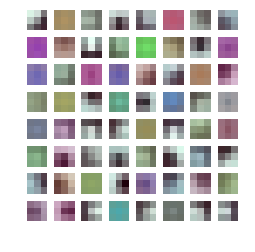

In [19]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

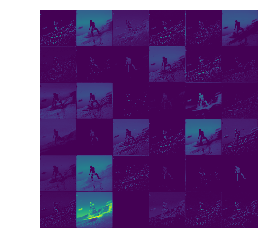

In [20]:
feat = net.blobs['conv1_1'].data[0, :36]
vis_square(feat)

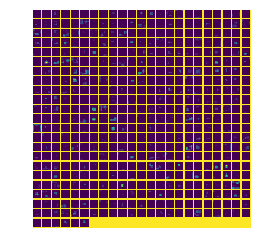

In [21]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

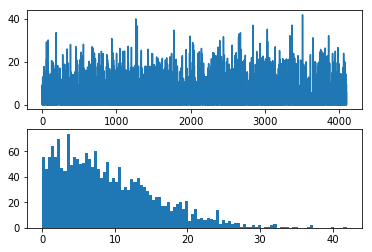

In [22]:
feat = net.blobs['fc6_retrain'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

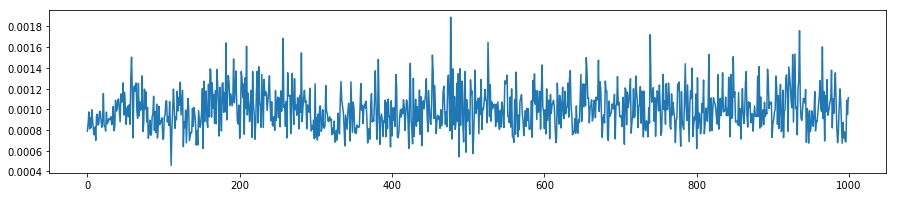

In [23]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

probabilities and labels:


[(0.0019327577, "n02966687 carpenter's kit, tool kit"),
 (0.0017338765, 'n07711569 mashed potato'),
 (0.0016878486, "n03992509 potter's wheel"),
 (0.0016757677, 'n03179701 desk'),
 (0.0016620838, 'n07880968 burrito')]

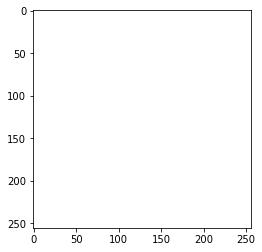

In [34]:
# transform it and copy it into the net
image = caffe.io.load_image('/home/gridsan/salford/white.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])